In [ ]:
# 生成人脸

In [1]:
# 导入相关包
import math
import numpy as np
import tqdm
import torch
from torchvision import utils

from model import StyledGenerator

from PIL import Image
import matplotlib.pyplot as plt

from smile_model import predictExpression

import torch.nn.functional as F


C:\conda\envs\face_edit\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## 生成图片
def make_image(tensor):
    return (
        tensor.detach()
        .clamp_(min=-1, max=1)
        .add(1)
        .div_(2)
        .mul(255)
        .type(torch.uint8)
        .permute(0, 2, 3, 1)
        .to("cpu")
        .numpy()
    )

## 获取平均风格向量W
@torch.no_grad()
def get_mean_style(generator, device):
    mean_style = None

    for i in range(30):
        # 从随机噪声向量Z，经过mapping network生成风格向量W
        style = generator.mean_style(torch.randn(1024, 512).to(device))

        if mean_style is None:
            mean_style = style

        else:
            mean_style += style
    # 平均风格（截断技巧）：https://blog.csdn.net/weixin_43135178/article/details/116331140
    # 
    mean_style /= 10
    return mean_style

## 根据风格向量生成样本
@torch.no_grad()
def sample(generator, step, mean_style, n_sample, device,style_weight):
    image = generator(
        torch.randn(n_sample, 512).to(device),
        step=step,
        alpha=1,
        mean_style=mean_style,
        style_weight=style_weight,  #截断用的权重 
    )
    
    return image


In [3]:
# 加载模型

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'checkpoint/stylegan-1024px-new.model'
# Z=512维向量，StyleGAN生成器
generator = StyledGenerator( code_dim=512, n_mlp=8 ).to(device)
# 载入预训练模型
generator.load_state_dict(torch.load(model_path)['g_running'])
generator.eval()

StyledGenerator(
  (generator): Generator(
    (progression): ModuleList(
      (0): StyledConvBlock(
        (conv1): ConstantInput()
        (noise1): NoiseInjection()
        (adain1): AdaptiveInstanceNorm(
          (norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (style): EqualLinear(
            (linear): Linear(in_features=512, out_features=1024, bias=True)
          )
        )
        (lrelu1): LeakyReLU(negative_slope=0.2)
        (conv2): EqualConv2d(
          (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (noise2): NoiseInjection()
        (adain2): AdaptiveInstanceNorm(
          (norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (style): EqualLinear(
            (linear): Linear(in_features=512, out_features=1024, bias=True)
          )
        )
        (lrelu2): LeakyReLU(negative_slope=0.2)
      )
      (1): Styled

In [4]:
#平均风格向量
mean_style = get_mean_style(generator,device) 
# 设置生成图像大小
img_size = 1024
#计算需要多少次上采样：1024需要8次
step = int(math.log(img_size, 2)) - 2

In [5]:
mean_style.shape

torch.Size([1, 512])

In [6]:
step

8

In [7]:
# 生成Latent z
latent_z = torch.randn(1, 512).to(device)

C:\conda\envs\face_edit\lib\site-packages\torch\nn\functional.py:3502: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


(512, 512, 3)


(-0.5, 511.5, 511.5, -0.5)

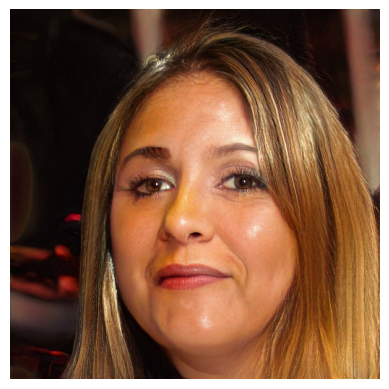

In [8]:
# 基于Z生成图片
img_gen = generator([latent_z], step=step) 
# 缩放
img_gen = F.interpolate(img_gen,scale_factor=0.5)
img_gen = make_image(img_gen)[0]
print(img_gen.shape)
plt.imshow(img_gen)
plt.axis('off')

In [9]:
# Z转为W
latent_w = generator.style(latent_z)

(-0.5, 511.5, 511.5, -0.5)

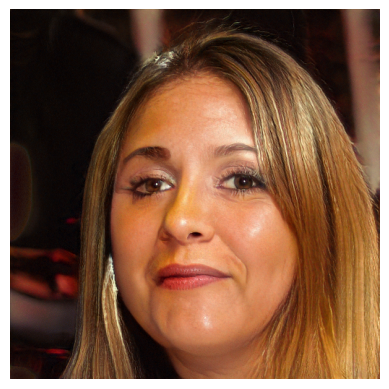

In [10]:
img_gen = generator([latent_z], mean_style = latent_w, step=step, style_weight=0) 
img_gen = F.interpolate(img_gen,scale_factor=0.5)
img_gen = make_image(img_gen)[0]

plt.imshow(img_gen)
plt.axis('off')


In [11]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [12]:
def discover(target_label,thresh=0.7,display=True,scale_factor=0.5):
    
    while True:
        # 生成Latent z
        latent_z = torch.randn(1, 512).to(device)
        # 基于Z生成图片
        img_gen = generator([latent_z], step=step) 
        # 缩放为原来的1/10
        img_gen = F.interpolate(img_gen,scale_factor=scale_factor)
        img_gen = make_image(img_gen)[0]

        label,score = predictExpression(img_gen)
        
        if label == target_label and score > thresh:
            
            if display:
                # 显示
                plt.imshow(img_gen)
                plt.title(label + ' ' + str(score))
                plt.axis('off')
                break
            else:
                # Z转为W
                latent_w = generator.style(latent_z)
                # 返回图片、Z、W
                return img_gen, latent_z[0].detach().cpu().numpy(), latent_w[0].detach().cpu().numpy()




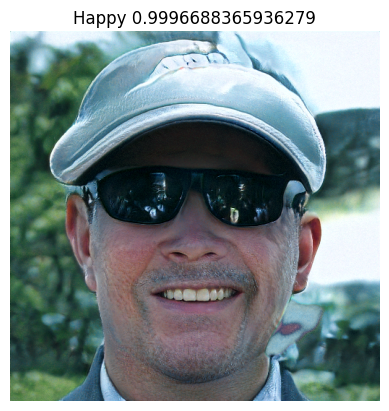

In [24]:
discover('Happy',0.99,scale_factor=0.5)

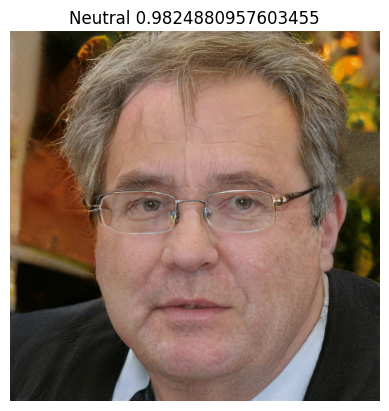

In [26]:
discover('Neutral',0.9,scale_factor=0.5)

In [27]:

def generateImgs(expression='Happy',nums=5000):
    # 各生成5000张，并保存他的Z、W向量

    pbar = tqdm.tqdm(range(nums))

    for index in pbar:
        img_gen,latent_z,latent_w = discover(expression,0.99,False,scale_factor=0.1)
        # 保存图片
        Image.fromarray(img_gen).save('./training_data_smile/images/{}_{}.jpg'.format(expression,index))
        # 保存向量
        np.save('./training_data_smile/z/z_{}_{}'.format(expression,index),latent_z)
        np.save('./training_data_smile/w/w_{}_{}'.format(expression,index),latent_w)    
        pbar.set_description('找到第{}张{}图片'.format(index+1,expression))




In [ ]:
# 寻找5000张微笑图
generateImgs(expression='Happy',nums=5000)

In [ ]:
# 寻找5000张正常图
generateImgs(expression='Neutral',nums=5000)